In [1]:
import sys

DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)

In [2]:
from comet_ml import API
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import shap
import pickle
import matplotlib.pyplot as plt
import sklearn
import imblearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, SelectFromModel
import os
import xgboost as xgb

from visualizations.simple_visualization import *
from models.generate_plots import *
from features.feature_eng1 import *

In [3]:
data = pd.read_csv(DATA_PATH + '/clean_test_data_playoffs.csv', index_col=0)

In [4]:
has_nan = data.isna().any().any()

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    # Dropping NaNs since these events do not have x and y coordinates
    data.dropna(inplace=True)
    data = data.reset_index(drop=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")

data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
data = data.reset_index(drop=True)

There are NaN values in the DataFrame 'X'.


In [5]:
api = API(api_key='lqXuPyhuPClaazZKtvHZe5jFS')

# Logistic Regression models
api.download_registry_model('ift6758b-project-b10', 'log_reg_basemodel_angle', version='1.2.0')
api.download_registry_model('ift6758b-project-b10', 'log_reg_basemodel_distance', version='1.1.0')
api.download_registry_model('ift6758b-project-b10', 'log_reg_basemodel_distance_angle', version='1.3.0')

# XGBoost model
api.download_registry_model('ift6758b-project-b10', '5-2-hyperparameter-tuned-xgboost', version='1.1.0')
# api.download_registry_model('ift6758b-project-b10', '5-3-xgboost-with-feature-selection', version='1.2.0')

# Adaboost model
api.download_registry_model('ift6758b-project-b10', 'adaboost-max-depth-10-v3', version='1.0.3')

COMET INFO: Downloading registry model 'log_reg_basemodel_angle', version '1.2.0', stage None from workspace 'ift6758b-project-b10'...
COMET INFO: Unzipping model to '/Users/udaykarankapur/Desktop/IFT 6758 Project/Repo/IFT6758B-Project-B10/Milestone2/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'log_reg_basemodel_distance', version '1.1.0', stage None from workspace 'ift6758b-project-b10'...
COMET INFO: Unzipping model to '/Users/udaykarankapur/Desktop/IFT 6758 Project/Repo/IFT6758B-Project-B10/Milestone2/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'log_reg_basemodel_distance_angle', version '1.3.0', stage None from workspace 'ift6758b-project-b10'...
COMET INFO: Unzipping model to '/Users/udaykarankapur/Desktop/IFT 6758 Project/Repo/IFT6758B-Project-B10/Milestone2/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model '5-2-hyperparameter-tuned-xgboost', version '1.1.0', stage None from workspace 'ift6758b-project-b10'...
C

In [6]:
log_reg_distance_model = pickle.load(open('log_reg_basemodel_distance_2023-11-16 00:42:39.348668.pkl','rb'))
log_reg_angle_model = pickle.load(open('log_reg_basemodel_angle_2023-11-16 00:42:39.348668.pkl','rb'))
log_reg_distance_angle_model = pickle.load(open('log_reg_basemodel_distance_angle_2023-11-16 00:42:39.348668.pkl','rb'))

In [7]:
y_preds = []
distance_preds = log_reg_distance_model.predict_proba(data[['shotDistance']])[:, 1]
y_preds.append(distance_preds)

X has feature names, but LogisticRegression was fitted without feature names


In [8]:
angle_preds = log_reg_angle_model.predict_proba(data[['shotAngle']])[:, 1]
y_preds.append(angle_preds)

X has feature names, but LogisticRegression was fitted without feature names


In [9]:
distance_angle_preds = log_reg_distance_angle_model.predict_proba(data[['shotDistance','shotAngle']])[:, 1]
y_preds.append(distance_angle_preds)

X has feature names, but LogisticRegression was fitted without feature names


In [10]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]

num_cols = X.select_dtypes([np.number]).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

categorical_cols = X.select_dtypes(exclude=["number", "bool_"]).columns
X = pd.get_dummies(data=X, columns=categorical_cols)

boolean_cols = X.select_dtypes([bool]).columns
X[boolean_cols] = X[boolean_cols].astype(int)
X = X.reset_index(drop=True)

# X = X.drop(['Rebound', 'shotType_Backhand', 'shotType_Deflected',
#            'shotType_Slap Shot', 'shotType_Snap Shot', 'shotType_Tip-In',
#            'shotType_Wrap-around', 'LastEventType_Goal', 'LastEventType_Shot'],axis=1)

In [11]:
xgb_hp_tune = pickle.load(open('hptuned_xgb_model.pkl','rb'))
hp_tune_preds = xgb_hp_tune.predict_proba(X)[:, 1]
y_preds.append(hp_tune_preds)

In [12]:
data = pd.read_csv(DATA_PATH + '/clean_test_data_playoffs_with_optional.csv', index_col=0)

has_nan = data.isna().any().any()

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    # Dropping NaNs since these events do not have x and y coordinates
    data.dropna(inplace=True)
    data = data.reset_index(drop=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")

data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
data = data.reset_index(drop=True)

X, y = data.iloc[:, :-1], data.iloc[:, -1]

num_cols = X.select_dtypes([np.number]).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

categorical_cols = X.select_dtypes(exclude=["number", "bool_"]).columns
X = pd.get_dummies(data=X, columns=categorical_cols)

boolean_cols = X.select_dtypes([bool]).columns
X[boolean_cols] = X[boolean_cols].astype(int)
X = X.reset_index(drop=True)

There are NaN values in the DataFrame 'X'.


In [13]:
X = X.drop(['period', 'Rebound', 'time_since_pp', 'no_players_home',
       'no_players_away', 'home_pts', 'away_pts', 'shotType_Backhand',
       'shotType_Deflected', 'shotType_Slap Shot', 'shotType_Snap Shot',
       'shotType_Tip-In', 'shotType_Wrap-around', 'shotType_Wrist Shot',
       'LastEventType_Goal', 'LastEventType_Shot'], axis=1)
adaboost_depth_10_model = pickle.load(open('ADABoost_rf_max_depth_10.pkl','rb'))
adaboost_preds = adaboost_depth_10_model.predict_proba(X)[:, 1]
y_preds.append(adaboost_preds)

X has feature names, but AdaBoostClassifier was fitted without feature names


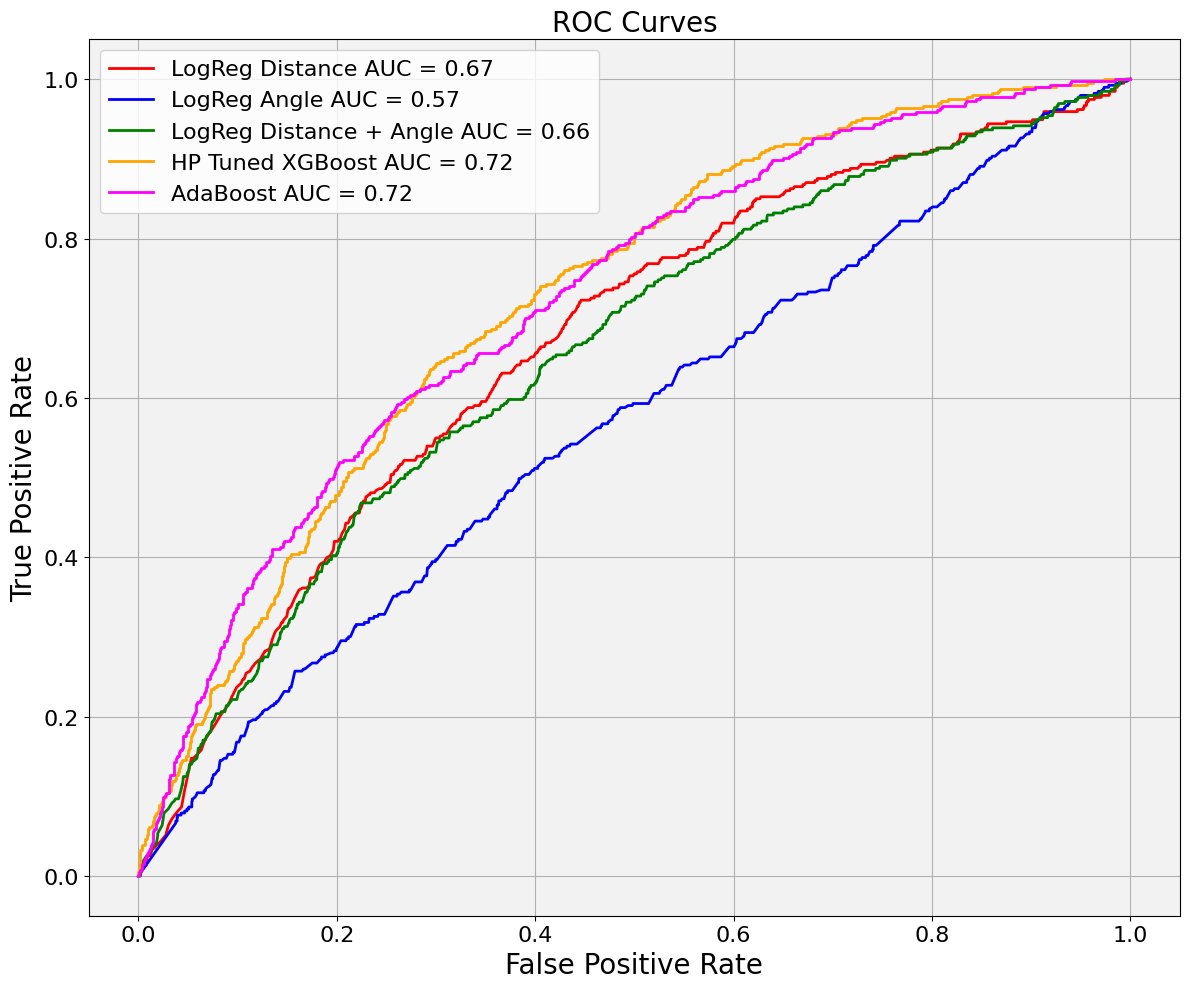

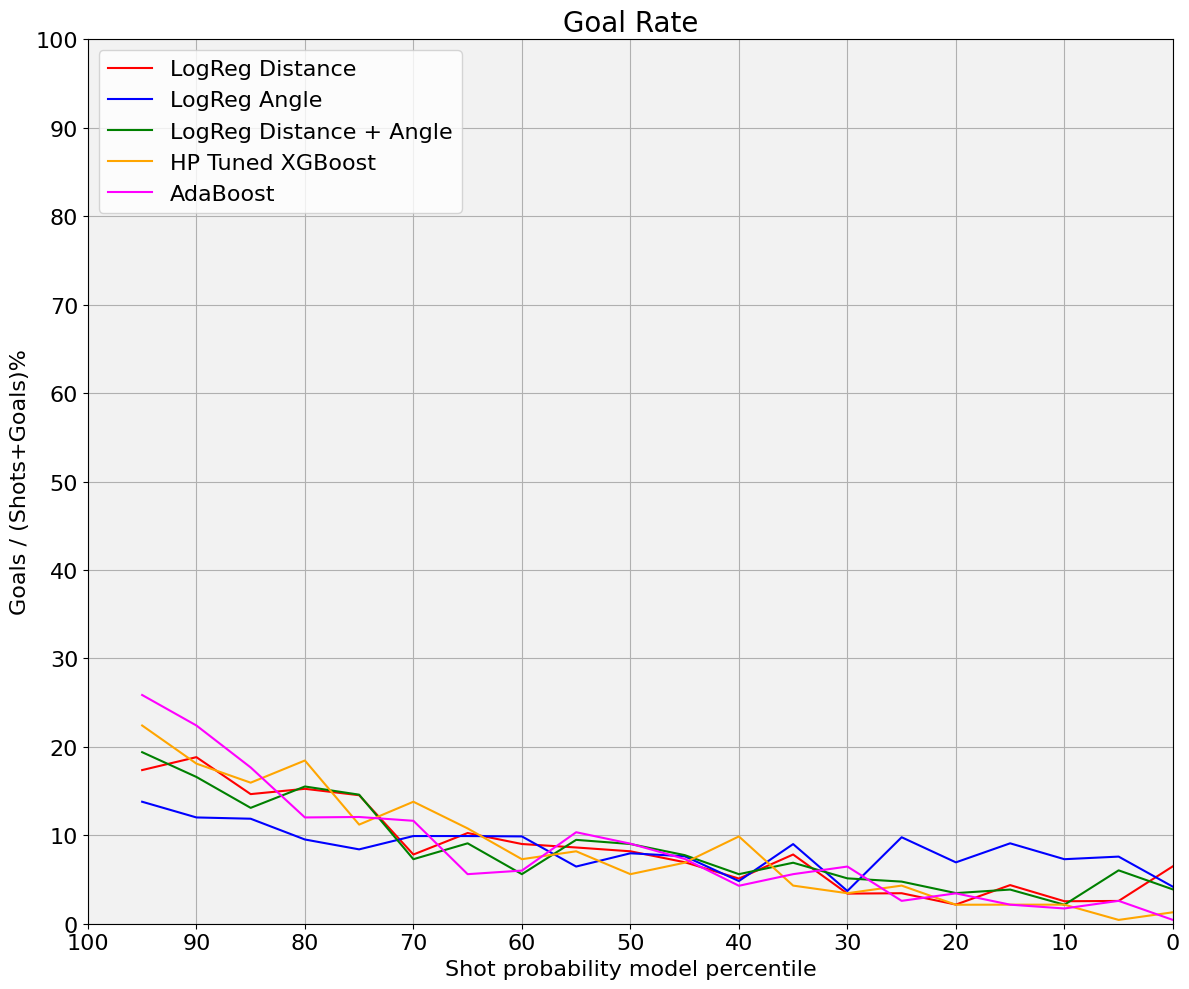

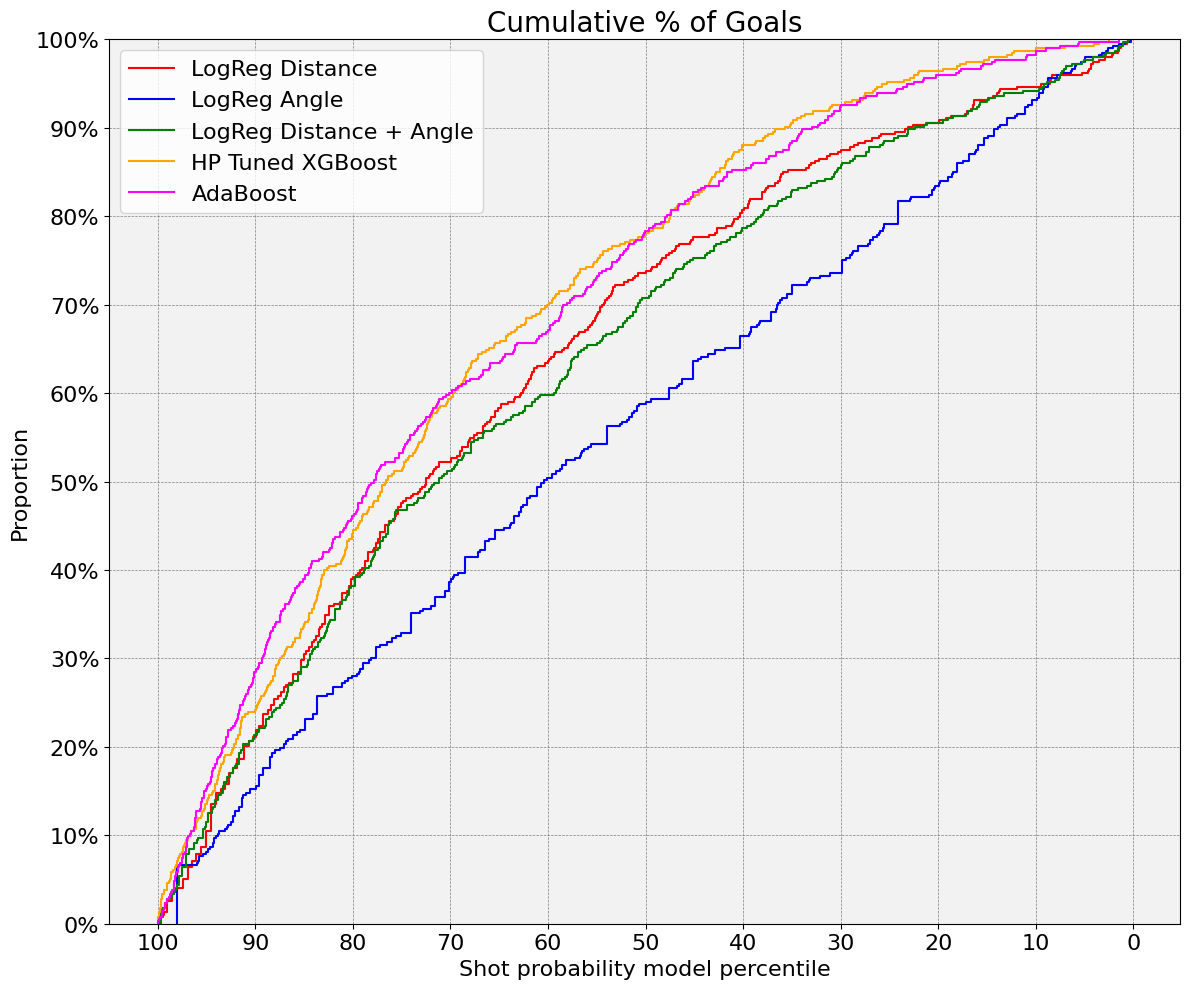

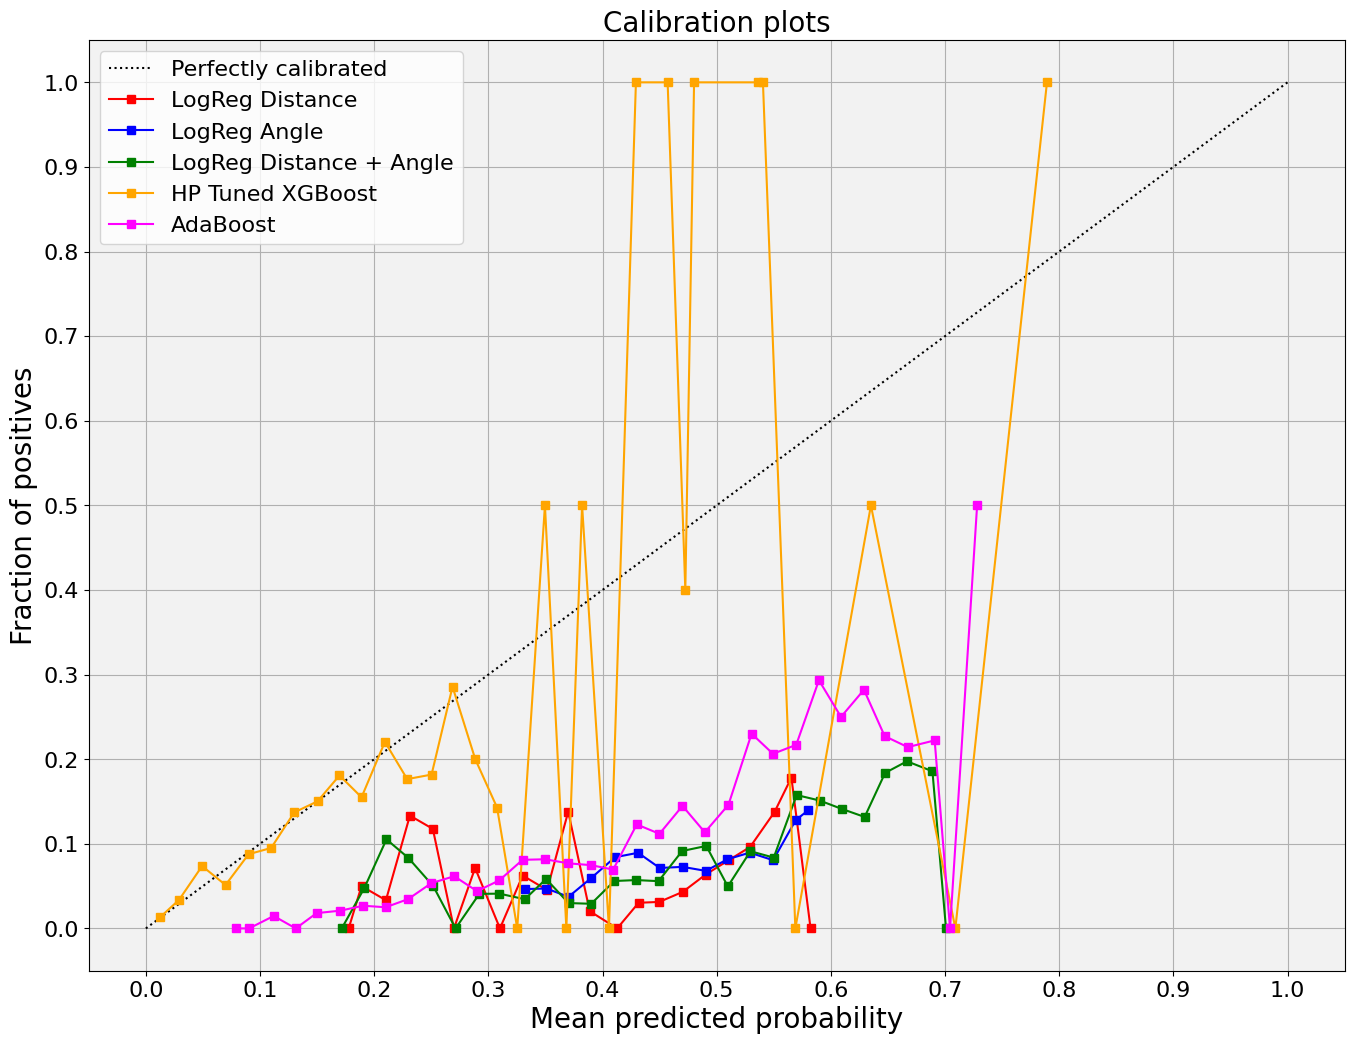

In [18]:
color_list = ['red', 'blue', 'green', 'orange', 'magenta']
model_list = ['LogReg Distance', 'LogReg Angle', 'LogReg Distance + Angle', 'HP Tuned XGBoost', 'AdaBoost']
plot_roc_all_feat(data[['is_goal']], y_preds, model_list, '7-2a-ROC', color_list, baseline=False)
plot_goal_rate_all_feat(data[['is_goal']], y_preds, model_list, '7-2b-goal-rate', color_list, baseline=False)
plot_cumulative_rate_all_feat(data[['is_goal']], y_preds, model_list, '7-2c-cumulative', color_list, baseline=False)
plot_calibration_all_feat(data[['is_goal']], y_preds, model_list, '7-2d-calibration', color_list)